Sources:

http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html
http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
https://github.com/ceteke/RL/blob/master/Approximation/Linear%20Sarsa.ipynb

## OpenAI Gym

OpenAI's `gym` is a toolkit for developing and comparing reinforcement learning algorithms. Standardized datasets have prove pivotal in development of deep learning algorithms. Similarly, collection of test problems, environments, as provided by `gym` aids in evaluation of reinforcement learning algorithms when an agent learns to take actions in response to observations from environment to "solve it".

This is what I will attempt in following, starting with the simplest of environments `CartPole-v0`.

*From `CartPole-v0` [Wiki page](https://github.com/openai/gym/wiki/CartPole-v0):*

#### Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

#### Observations

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

#### Actions

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right


#### Reward
Reward is 1 for every step taken, including the termination step.

#### Episode Termination
1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

#### Solved Requirements
Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

First let's take a look how the environment looks like:

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
# matplotlib.use("Agg") # use noninteractive backend
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym
import gym.spaces

# plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':14,'axes.labelsize':18,'axes.titlesize':18,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)
# %matplotlib Agg

gym.logger.set_level(40)
gym.__version__

'0.10.5'

In [8]:
env = gym.make('CartPole-v0')

# Run a demo of the environment
cum_reward = 0
frames = []
num_episodes = 10

for ep in range(num_episodes):
    observation = env.reset()
    for t in range(500):
        # Render into buffer. 
        frames.append(env.render(mode = 'rgb_array'))
        action = env.action_space.sample() # Draw random action
        # Run one timestep of the environment's dynamics
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode {} of {} finished after {} time steps."\
                  .format(ep, num_episodes, t+1))
            break
env.close()

fig, ax = plt.subplots(1, 1)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval=5,
                              blit = False, repeat = False)

Episode 0 of 10 finished after 22 time steps.
Episode 1 of 10 finished after 13 time steps.
Episode 2 of 10 finished after 19 time steps.
Episode 3 of 10 finished after 20 time steps.
Episode 4 of 10 finished after 16 time steps.
Episode 5 of 10 finished after 18 time steps.
Episode 6 of 10 finished after 52 time steps.
Episode 7 of 10 finished after 12 time steps.
Episode 8 of 10 finished after 34 time steps.
Episode 9 of 10 finished after 15 time steps.


Next, try to solve it:

**TODO: Provide theory for SARSA**
- on policy
- s,a,r,s,a
- recommended for safe solutions

https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial2/README.md

As this is my first reinforcement learning project, I will take inspiration from  some successful implementations from cartpole leaderboard, e.g. [ceteke's](https://github.com/ceteke/RL/blob/master/Approximation/Linear%20Sarsa.ipynb)

In [2]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import random

# Linear approximation function to expected returns
def approx(weights, observation, action):
    return np.dot(observation, weights)[action]


def policy(env, weights, observation, epsilon):
    actions = [0, 1]
    if np.random.rand() < epsilon:
        return random.choice(actions)
    
    qs = []
    for action in actions:
        qs.append(approx(weights, observation, action))
    return np.argmax(qs)

dapprox = grad(approx)
discount = 1.0 # Discount rate
epsilon = 0.2 # Exploration rate
alpha = 0.1 # Step size for gradient descent
w = np.zeros((4,2)) # Initalize weigths 
num_episodes = 1000 # Number of games for the agent to play
max_steps = 200

In [10]:
import os
import tempfile
import subprocess
anim_path = "./monitor"
if not os.path.isdir(anim_path): os.makedirs(anim_path)
    
def save_frames(frames, anim_path):
    temp_dir = tempfile.mkdtemp(dir = anim_path)
    for i, frame in enumerate(frames[-200:]):
        plt.imsave(*("{}/{}.png".format(temp_dir, i), frame),
                        **{"vmin":0, "vmax":255})
    subprocess.run("ffmpeg -y -f image2 -i {0}/%d.png {0}/video.avi".format(temp_dir),
                        shell = True)
    subprocess.run("ffmpeg -y -i {}/video.avi -r 9 {}/anim.gif".format(temp_dir, anim_path),
                        shell = True)
    
    os.rmdir(temp_dir)
        

In [3]:
env = gym.make('CartPole-v0')
episode_rewards = []
for ep in range(num_episodes):
    state = env.reset()
    rewards = []
    for _ in range(max_steps):
        # Take smart action based on defined policy
        action = policy(env, w, state, epsilon)
        
        q_hat = approx(w, state, action)
        q_hat_grad = dapprox(w, state, action)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        # Render into buffer. 
        # env.render()
        # visframe = env.render(mode = 'rgb_array')
        # frames.append(visframe)
        if done:
            w += alpha*(reward - q_hat) * q_hat_grad
            break
        else:
            # Update weights to maximize for reward
            next_action = policy(env, w, next_state, epsilon)
            q_hat_next = approx(w, next_state, next_action)
            w += alpha*(reward - discount*q_hat_next)*q_hat_grad
            state = next_state
    # Exploration / Explotation Tradeoff
    # as we learn more about the game, become more certain in making decision
    if ep == 100:
        epsilon /= 2
        
    episode_rewards.append(np.sum(rewards))
    mean_reward=np.mean(episode_rewards[max(ep-100, 0):ep+1])
    
    # Report on progress - did we solve the task already?
    if mean_reward >= 195.0 and ep >= 100:
        print("Episodes before solve {}".format(ep-100+1))
        # save_frames(frames, anim_path)
        break
    if ((ep % 100) == 0) and ep > 0:
        print("Episode {}/{} finished. Mean reward over last 100 episodes: {:.2f}"\
              .format(ep, num_episodes, (mean_reward)))
env.close()

Episode 100/1000 finished. Mean reward over last 100 episodes: 148.12
Episodes before solve 69


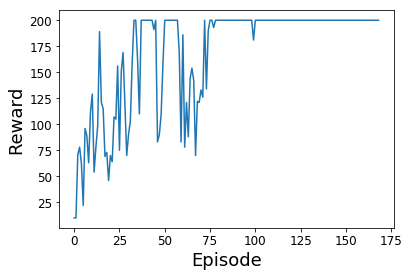

In [4]:
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [5]:
?plt.plot

If lucky, can solve the challenge already after 50 episodes (which is #2 on the leaderboard!).

In [ ]:
# fig, ax = plt.subplots(1, 1)
# patch = plt.imshow(frames[0])
# plt.axis('off')

# def animate(i):
#     patch.set_data(frames[i])

# anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval=5,
#                               blit = False, repeat = False)

We have already solved the problem, but I wonder how will a neural network perform.

**TODO:**
- Q-learning introduction (off-policy)
- briefly about the model (what does it do, can be replaced by some linear function)
- prioretized experience replay

https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial5/README.md

Inspiration from [here](https://gist.github.com/mbalunovic/fb7392e2c09b2c3895a354c3ad36497e#file-cartpole_q_network-py) and [here](https://github.com/facebookresearch/BlueWhale/blob/da1209deacaebdc7ef01daf06719cf1a03e0f5a4/ml/rl/test/gym/discrete_qlearn_softmax_cartpole_v0.json)

[Good introduction](https://keon.io/deep-q-learning/)

In [1]:
%load_ext autoreload
%autoreload 2

import cartpole

from keras import __version__ as K_ver
from keras.backend import _config as K_cf
from tensorflow import __version__ as tf_ver
print("Tensorflow version: {}".format(tf_ver))
print("Keras version: {}".format(K_ver))
print("Keras config: \n")
K_cf

/home/mholub/miniconda3/envs/dl36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow version: 1.8.0
Keras version: 2.1.5
Keras config: 



{'floatx': 'float32',
 'epsilon': 1e-07,
 'backend': 'tensorflow',
 'image_data_format': 'channels_last'}

In [2]:
# Set up environment, build model
env_params = cartpole.envParams(num_episodes = 500, discount = .99,
                                epsilon = 1., eps_decay_rate = 0.99,
                                eps_min = 0.1, max_steps = 200,
                                env_id = "CartPole-v0")
model_params = cartpole.modelParams(learn_rate = 0.001, num_epochs = 1,
                                    replay_size = 64, max_memory = 20000,
                                    hidden_size = 16)
# Set up Deep Q-Learnibng Agent
agent = cartpole.dqnAgent(model_params, env_params)
# Make solver object
solver = cartpole.cartPoleSolver(agent, verbose = True)
# Attempt solving the environemnt
solver.main()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
2018-07-10 23:00:44,845:cartpole:INFO: None
2018-07-10 23:00:44,849:cartpole:INFO: Starting `cartpole` game.
2018-07-10 23:00:44,850:cartpole:IN

BdbQuit: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
2018-05-21 13:58:28,676:cartpole:INFO: None
2018-05-21 13:58:28,710:cartpole:INFO: Starting `cartpole` game.
2018-05-21 13:58:28,725:cartpole:IN

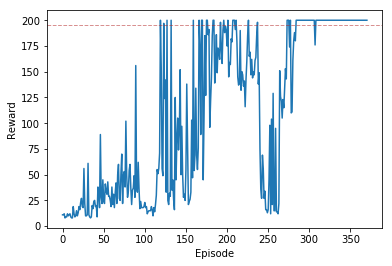

2018-05-21 14:00:59,728:cartpole:INFO: Game finished.


In [2]:
# Set up environment, build model
env_params = cartpole.envParams(num_episodes = 500, discount = 1.0,
                                epsilon = 0.2, eps_decay_rate = 0.99,
                                eps_min = 0.001, max_steps = 200,
                                env_id = "CartPole-v0")
model_params = cartpole.modelParams(learn_rate = 0.001, num_epochs = 1,
                                    replay_size = 64, max_memory = 2000,
                                    hidden_size = 16)
# Set up Deep Q-Learnibng Agent
agent = cartpole.dqnAgent(model_params, env_params)
# Make solver object
solver = cartpole.cartPoleSolver(agent, verbose = True)
# Attempt solving the environemnt
solver.main()